# __Step 5.1: Species over time__

Goals here:
- Determine overall genus mention
- Determine genus mention over time
- Same analysis at other taxonmic levels

Considerations:
- Deal with common names
  - Common names must be those in the USDA common name database.
  - If some non-specific names are mentioned, even though they most likely refer to a particular species frequently, they will not be counted.
- Deal with synonyms
  - Both NCBI and USDA data have synonym info. They will be pointed to a specific level.
- Deal with redundancy
  - It is possible that multiple taxa levels are mentioned in a single title/abstract: e.g., Solanceae, Solanum, tomato. At the genus level, it will be counted just one time at both the family and the genus levels for this record.
- Missing info
  - Some species info may be mentioned only in the full text.
- NCBI compressed taxa dump was downloaded in 11/11/2021. Notice that some taxa names are found in USDA common names and in NCBI taxonomy website, but not in the names.dmp.
  - Example: Achnatherum  
  - One level up, tribe Stipeae, only have 25 children when there should be 34. Missing: Barkworthia, Eriocoma, Neotrinia, Oryzopsis (ricegrass), Pseudoeriocoma, Ptilagrostiella, Stipellula, Thorneochloa, x Eriosella.
  - Download the taxnomy dump again from [here](https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/new_taxdump/new_taxdump.tar.gz) on 9/20/22. 
- 9/21/20: Realized that I need to include `no_rank` taxa when parse parent-child relations, otherwise, the lineage will be broken.
- 9/22/22: 
  - The parallelized get_match_csr did not finish due to memory issue: the returned lists eat up >60GB and went into SWAP, and I got the broken pipe error. Fix this by sending only a subset of rows at a time, then save the csr for the subset for stacking them together later.
  - The parallelized version did not generate results in order. See [this post](https://stackoverflow.com/questions/40684168/multiprocessing-pool-map-not-processing-list-in-order) to fix.
  - For common names, the string should be checked with lower case.
- 9/23/22: Realize that the genus_names have duplicated components. Fixed.
- 9/26/22: 
  - `ts_genus_count_df` index not sorted. So the timestamps are out of order. Fixed.
  - Three genus dropped because their common names are too common. See `Remove certain genus` section.

## ___Set up___

### Module import

In [59]:
import pickle, nltk, re, multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix, dok_matrix
from time import time
from datetime import datetime
from collections import OrderedDict, Counter
from bisect import bisect
from mlxtend.preprocessing import minmax_scaling

### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "5_species_over_time/"
work_dir.mkdir(parents=True, exist_ok=True)

# species information
# NEED TO SPECIFY
# NEED TO SPECIFY
dir1           = proj_dir / "1_obtaining_corpus"
#names_dmp_path = dir1 / "taxonomy/names.dmp"
#nodes_dmp_path = dir1 / "taxonomy/nodes.dmp"
usda_plant_db  = dir1 / "usda/USDA_Plants_Database.txt"

names_dmp_path = work_dir / "taxonomy/names.dmp"
nodes_dmp_path = work_dir / "taxonomy/nodes.dmp"

# plant science corpus with date and other info
dir2        = proj_dir / "2_text_classify//2_5_predict_pubmed"
corpus_file = dir2 / "corpus_plant_421658.tsv.gz"

# timestamp bins
dir44            = proj_dir / "4_topic_model/4_4_over_time"
ts_for_bins_file = dir44 / "table4_4_bin_timestamp_date.tsv"

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Get plant names___

In `1_obtaining_corpus`, plant names are from two sources:
- NCBI: the taxonomy database with mention of all taxa levels
  - This will also contain synonyms for different levels.
- USDA: plant common names with species information


### NCBI taxonomy

Functions modified from:
- `1_obtaining_corpus\script_get_plant_taxa.py`

#### Parse name_dmp

In [3]:
#
# For: Getting the tax_id of Viridiplantae and generate a dictionary.
# Parameters
#   names_dmp_file - The Path object to the names.dmp file from NCBI taxonomy.
#   target - Target taxon name.
# Return:
#   target_id - The NCBI taxon ID for the taxon.
#   names_dic - A dictionary with: {tax_id:{name_class:[names]}
#
def get_name_dict(names_dmp_path, target):
  target_id = ""
  names_dmp = open(names_dmp_path)
  L         = names_dmp.readline()
  names_dic = {}
  while L != "":
    L = L.strip().split("\t")
    tax_id = L[0]
    name   = L[2]
    name_c = L[6]
    if L[2] == target:
      print(f"{target} tax_id:",tax_id)
      target_id = tax_id

    if tax_id not in names_dic:
      names_dic[tax_id] = {name_c:[name]}
    elif name_c not in names_dic[tax_id]:
      names_dic[tax_id][name_c] = [name]
    else:
      names_dic[tax_id][name_c].append(name)
    L = names_dmp.readline()
  return target_id, names_dic

In [4]:
viridi_id, viridi_names_dic = get_name_dict(names_dmp_path, 'Viridiplantae')

Viridiplantae tax_id: 33090


In [5]:
viridi_names_dic['33090'], viridi_names_dic['147383']

({'authority': ['Chlorobionta Jeffrey, 1982',
   'Chloroplastida Adl et al. 2005',
   'Viridiplantae Cavalier-Smith, 1981'],
  'synonym': ['Chlorobionta', 'Chloroplastida'],
  'equivalent name': ['Chlorophyta/Embryophyta group',
   'chlorophyte/embryophyte group'],
  'blast name': ['green plants'],
  'common name': ['green plants'],
  'scientific name': ['Viridiplantae']},
 {'authority': ['Stipeae Dumort., 1824'], 'scientific name': ['Stipeae']})

#### Parse node_dmp

This is to get:
- Parent-child relation
- Child-parent relation
- Rank count:
- Taxa_id-rank relation


In [6]:
#
# For: Get the parent-child relationships from nodes.dmp file.
# Parameters: 
#   nodes_dmp_path - The Path object to the nodes.dmp file from NCBI taxonomy.
# Return: 
#   parent_child - A dictionary with {parent:[children]}
#
def get_parent_child(nodes_dmp_path):
    nodes_dmp    = open(nodes_dmp_path)
    L            = nodes_dmp.readline()
    rank_d       = {} # {rank: count}
    taxa_rank    = {} # {taxa_id: rank}
    rank_taxa    = {} # {rank: taxa_id}
    parent_child = {}
    child_parent = {}
    target_ranks = ['genus', 'family', 'order']

    debug_count  = 0
    debug_list   = []
    while L != "":
        L = L.strip().split("\t")
        tax_id = L[0]
        par_id = L[2]
        rank   = L[4]
        if rank not in rank_d:
            rank_d[rank] = 1
        else:
            rank_d[rank]+= 1
        
        # Don't want any species or taxon with no rank
        # 9/20/22: actually, do not want no rank result in problem. Am example
        #   is taxid=2822797, child of 147368, this lead to some taxa missing.
        #   so removed.
        #if rank not in ["no rank", "species"]:
        if rank != "species":
            # debug
            if par_id == '147383':
                debug_count += 1
                debug_list.append(
                                viridi_names_dic[tax_id]['scientific name'][0])
                #print(debug_count, tax_id, names_dic[tax_id]['scientific name'])

            # populate parent_child dict
            if par_id not in parent_child:
                parent_child[par_id] = [tax_id]
            else:
                parent_child[par_id].append(tax_id)
            
             # populate child_parent dict
            if tax_id not in child_parent:
                child_parent[tax_id] = par_id
            else:
                print(f"ERR: {tax_id} with >1 parents",
                        child_parent[tax_id], par_id)
            
            # populate taxa_rank and rank_taxa dicts
            taxa_rank[tax_id] = rank
            
            if rank not in rank_taxa:
                rank_taxa[rank] = [tax_id]
            else:
                rank_taxa[rank].append(tax_id)
            
        L = nodes_dmp.readline()
        
    return parent_child, child_parent, rank_d, taxa_rank, rank_taxa, debug_list

In [7]:
parent_child, child_parent, rank_d, taxa_rank, rank_taxa, debug_list = \
                                              get_parent_child(nodes_dmp_path)

#### Get offsprings of Viridiplantae

These are the names to search for, after adding the USDA names.

In [8]:
#
# For: Get the offsprings of a parent.
# Parameters: 
#   p - The parent taxa ID to get children for.
#   paren_child - The dictionary returned from get_parent_child().
#   offsprings - An initially empty list to append offspring IDs.
# Return: 
#   offsprings - The populated offspring list.
#
def get_offsprings(p, parent_child, offsprings, debug=0):
    if debug:
        print(p)
    if p in parent_child:
        # Initialize c with an empty element for debugging purpose
        #c = [""]
        c = parent_child[p]
        if debug:
            print("",p, c)
            if p == "147383":
                print("debug parent found")

        offsprings.extend(c)
        for a_c in c:
            get_offsprings(a_c, parent_child, offsprings)
    else:
        if debug:
            print(" NO CHILD")
    return offsprings

In [10]:
viridi_offspr = get_offsprings(viridi_id, parent_child, [])
len(viridi_offspr)

25232

In [11]:
# Convert taxa id into scientific names
viridi_offspr_names = []
redun = {}
for o in viridi_offspr:
    if o in viridi_names_dic:
        for nc in viridi_names_dic[o]: # for each name_class
            if nc != 'authority': 
                for name in viridi_names_dic[o][nc]:
                    if name not in redun:
                        viridi_offspr_names.append(name)
                        redun[name] = 0
                    #else:
                    #    print("Redun:", name)

# Note that this number is larger than offspring_33090 which contain indicies
# This is because there are other names, like synonyms for each index.
len(viridi_offspr_names)

26782

In [38]:
# Check if there is any duplicate name
def check_duplicate(alist):
  dup = [item for item, count in Counter(alist).items() if count > 1]
  print("duplicated:", dup)

In [39]:
check_duplicate(viridi_offspr_names)

duplicated: []


In [14]:
# Save as pickle
with open(work_dir / "viridiplantae_offspring_names.pickle", "wb") as f:
  pickle.dump(viridi_offspr_names, f)

### USDA names

Functions modified from:
- `1_obtaining_corpus\script_get_plant_common_names.py`

In [15]:
cnames = {} # {common_name:[scientific name, family]}

with open(usda_plant_db) as f:
    f.readline() # header, don't need it
    L = f.readline()
    while L != "":
        L = L.strip()
        # There is empty line in the file.
        if L == "":
            break
        #print(L.split(","))
        try:
            # some names have "," in there. So need to split with ""\,"
            [symbol, synonym, sname, cname, fam] = L.split("\",")
        except ValueError:
            print("ValueError:",[L])
            break
        # rid of quotes
        
        [symbol, synonym, sname, cname, fam] = [symbol.split("\"")[1], 
                                                synonym.split("\"")[1], 
                                                sname.split("\"")[1], 
                                                cname.split("\"")[1], 
                                                fam.split("\"")[1]]
        #print([symbol, synonym, sname, cname, fam])
        # Get genus name out
        genus = sname.split(" ")[0]

        if cname != "":
            if cname not in cnames:
                cnames[cname] = [genus, fam]
            #else:
            #    print("Redun cname:", [cname], cnames[cname], [sname,fam])        
        L = f.readline()

In [16]:
# Save as pickle
with open(work_dir / "usda_common_names_dict.pickle", "wb") as f:
  pickle.dump(cnames, f)

### Rid of USDA names not found in the NCBI list

In [18]:
# Check if all USDA genus names are found in NCBI
# This helped identified issues with the parent_child script and missing data
# due to the use of older NCBI taxa dump file. Currently, missings ones are 
# fungal and are excluded.
cnames_overlap = {}
for cname in cnames:
  genus = cnames[cname][0]
  if genus in viridi_offspr_names:
    cnames_overlap[cname] = genus

In [19]:
common_names = list(cnames_overlap.keys())

In [20]:
# Save as pickle
with open(work_dir / "usda_common_names.pickle", "wb") as f:
  pickle.dump(common_names, f)

## ___Find names in corpus___

### Read and preprocess corpus

In [22]:
corpus = pd.read_csv(corpus_file, compression='gzip', sep='\t')
corpus.shape

(421658, 11)

In [23]:
# Function based on Mauro Di Pietro (2020):
#  https://towardsdatascience.com/text-classification-with-no-model-training-935fe0e42180
# For the purpose here, did not do lower-casing
def utils_preprocess_text(text, lst_stopwords, flg_stemm=False, flg_lemm=True):
    '''
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    '''
    ## clean: stripping, then removing punctuations.
    text = str(text).strip()
    
    # RE: replace any character that is not alphanumeric, underscore, whitespace
    #  with ''. Originally this is it, but realized that biological terms have
    #  special characters including roman numerals, dash, and ",". So they are
    #  not removed.
    #text = re.sub(r'[^\w\s(α-ωΑ-Ω)-,]', '', text)
    # Use the original method
    text = re.sub(r'[^\w\s]', '', text)

    ## Tokenize (convert from string to list)
    lst_text = text.split()    
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [24]:
tqdm.pandas(desc="Clean text")
lst_stopwords       = nltk.corpus.stopwords.words("english")
corpus["txt_clean"] = corpus["txt"].progress_apply(lambda x: 
                                        utils_preprocess_text(x, lst_stopwords))
corpus.sample(2)

Clean text: 100%|██████████| 421658/421658 [04:39<00:00, 1506.12it/s]


,Unnamed: 0,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,reg_article,y_prob,y_pred,txt_clean
321338,1165023,28742234,2017-07-26,Molecular plant pathology,Xylella fastidiosa: an examination of a re-eme...,Xylella fastidiosa is a Gram-negative bacteria...,plant,Xylella fastidiosa: an examination of a re-eme...,1,0.718540,1,Xylella fastidiosa examination reemerging plan...
69943,385690,12706717,2003-04-23,Journal of molecular biology,Motif refinement of the peroxisomal targeting ...,"Eukaryote peroxisomes, plant glyoxysomes and t...",plant,Motif refinement of the peroxisomal targeting ...,1,0.767757,1,Motif refinement peroxisomal targeting signal ...


In [25]:
corpus["txt_clean"].to_csv(work_dir / "txt_clean.csv")

### Find names and load csr

- Update csr values
  - https://stackoverflow.com/questions/56981077/how-to-update-value-in-csr-matrix
- See code testing section on the different functions tried
- Get the full csr in `script_5_1a_find_names.ipynb`, which is (421658, 26782).

In [26]:
# load the saved csr
with open(work_dir / "match_csr.pickle", "rb") as f:
  match_csr = pickle.load(f)

## ___Time bins___

Based on codes from `script_4_4_over_time.ipynb`.

### Get binned timestamp values

In [30]:
dates = corpus['Date']

# Turn all dates into timestamps 
ts_for_bins = []
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  dt   = datetime(int(yr), int(mo), int(da))
  ts   = dt.timestamp()
  ts_for_bins.append(ts)
ts_for_bins.sort()

# bin size
bin_size       = int(len(ts_for_bins)/50)

# index values of every 2 percentile (because the data is broken into 50 parts)
bin_idxs       = [idx for idx in range(0, len(ts_for_bins), bin_size)]

# timestamp values at bin_idxs
bin_timestamps = [ts_for_bins[idx] for idx in bin_idxs]

# Modify the last value to be the max timestamp value + 1. This is otherwise
# because of the bin_size is rounded down the last value be smaller than the max
# timestamp values. Also, +1 to the max value, otherwise, the last entries will
# be in its own bin.
max_timestamp      = max(ts_for_bins) + 1
bin_timestamps[-1] = max_timestamp

# dates correspond to the different timestamp
bin_dates = [datetime.fromtimestamp(ts) for ts in bin_timestamps]

# Put idx, timestamp, and date into a dataframe and save it.
bin_df    = pd.DataFrame(list(zip(bin_idxs, bin_timestamps, bin_dates)),
            columns=['bin_start_idx', 'bin_start_timestamp', 'bin_start_date'])
bin_df.head()

,bin_start_idx,bin_start_timestamp,bin_start_date
0,0,-1.646248e+09,1917-11-01
1,8433,2.507508e+08,1977-12-12
2,16866,4.258800e+08,1983-07-01
3,25299,5.468400e+08,1987-05-01
4,33732,6.389460e+08,1990-04-01


### Generate the binned timestamps

In [31]:
# Assign new timestamps based on the bin timestamp values
ts_in_bins = []
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  dt   = datetime(int(yr), int(mo), int(da))
  ts   = dt.timestamp()

  bin_idx = bisect(bin_timestamps, ts)

  if bin_idx < len(bin_timestamps):
    ts2     = bin_timestamps[bin_idx]
  # Deal with the last bin
  else:
    ts2     = datetime(2022, 12, 31).timestamp()
  ts_in_bins.append(ts2) 

In [32]:
len(ts_in_bins), ts_in_bins[:2]

(421658, [250750800.0, 250750800.0])

### Include timestamps and bin range info in corpus

In [33]:
# These are binned values
timestamps = ts_in_bins

# Create a new dataframe with PMID, date, txt_clean, bin, and bin_left
documents = pd.DataFrame({"PMID": corpus['PMID'], "Date": corpus['Date'], 
                          "txt_clean": corpus['txt_clean'], 
                          "Timestamps":timestamps})
documents = documents.sort_values("Timestamps")
documents.head()

,PMID,Date,txt_clean,Timestamps
0,61,1975-12-11,Identification 120 mu phase decay delayed fluo...,250750800.0
242511,24499983,1970-03-01,The inhibition high concentration 2chloroethyl...,250750800.0
242513,24500013,1970-06-01,The autoradiographic identification tritiated ...,250750800.0
242514,24500015,1970-06-01,Investigations growth metabolism cultured expl...,250750800.0
242515,24500016,1970-06-01,Phytochrome appearance distribution embryonic ...,250750800.0


In [34]:
# a list of tuples showing the bin range (+/-1 of the unique val)
ts_bins   = [pd.Interval(left=ts-1, right=ts+1) for ts in timestamps] 

documents["Bins"]      = ts_bins
documents["Bins_left"] = documents.apply(lambda row: row.Bins.left, 1)

documents.head(2)

,PMID,Date,txt_clean,Timestamps,Bins,Bins_left
0,61,1975-12-11,Identification 120 mu phase decay delayed fluo...,250750800.0,"(250750799.0, 250750801.0]",250750799.0
242511,24499983,1970-03-01,The inhibition high concentration 2chloroethyl...,250750800.0,"(250750799.0, 250750801.0]",250750799.0


In [35]:
#https://www.statology.org/pandas-select-rows-by-index/
documents.loc[242511]

PMID                                                   24499983
Date                                                 1970-03-01
txt_clean     The inhibition high concentration 2chloroethyl...
Timestamps                                          250750800.0
Bins                                 (250750799.0, 250750801.0]
Bins_left                                           250750799.0
Name: 242511, dtype: object

In [36]:
ts_unique = documents.Bins_left.unique()
ts_unique.sort()
len(ts_unique), ts_unique

(50,
 array([2.50750799e+08, 4.25879999e+08, 5.46839999e+08, 6.38945999e+08,
        7.12641599e+08, 7.78391999e+08, 8.36193599e+08, 8.97537599e+08,
        9.49726799e+08, 9.86961599e+08, 1.01841120e+09, 1.04649480e+09,
        1.07224200e+09, 1.09928520e+09, 1.12304160e+09, 1.14619680e+09,
        1.16762760e+09, 1.18861920e+09, 1.20900960e+09, 1.22594760e+09,
        1.24572960e+09, 1.26413640e+09, 1.28262240e+09, 1.30016160e+09,
        1.31614560e+09, 1.33230240e+09, 1.34733600e+09, 1.36220040e+09,
        1.37593440e+09, 1.38976200e+09, 1.40220000e+09, 1.41490080e+09,
        1.42734240e+09, 1.43969760e+09, 1.45197000e+09, 1.46371680e+09,
        1.47589920e+09, 1.48739400e+09, 1.49896800e+09, 1.51037640e+09,
        1.52186400e+09, 1.53275040e+09, 1.54398600e+09, 1.55417760e+09,
        1.56402720e+09, 1.57405320e+09, 1.58355720e+09, 1.59271200e+09,
        1.60143840e+09, 1.60947720e+09]))

## ___Genus level counts___

### Get genus level tax_id and names

In [40]:
# a list of genus tax_ids
genus_taxids = rank_taxa["genus"]
len(genus_taxids), genus_taxids[:3], check_duplicate(genus_taxids)

duplicated: []


(104243, ['6', '10', '13'], None)

In [41]:
# convert tax_ids to scientific names, note that this contain ALL genus names
# not restricted to those in viridiplantae
genus_names_dict = {viridi_names_dic[tax_id]['scientific name'][0]:1
                    for tax_id in genus_taxids}
genus_names = list(genus_names_dict.keys())
len(genus_names), genus_names[:3], check_duplicate(genus_names)

duplicated: []


(103230, ['Azorhizobium', 'Cellvibrio', 'Dictyoglomus'], None)

In [42]:
# Get match_csr column index for genus names: there are 17512 genus names in
# among Viridiplantae taxa

# convert list to dict for more efficient operation
viridi_offspr_dict = {name:1 for name in viridi_offspr_names}

#https://stackoverflow.com/questions/50756085/how-to-print-the-progress-of-a-list-comprehension-in-python
genus_csr_idx   = [viridi_offspr_names.index(name) for name in tqdm(genus_names)
                   if name in viridi_offspr_dict]
len(genus_csr_idx)

100%|██████████| 103230/103230 [00:12<00:00, 7991.16it/s] 


16794

In [43]:
# Also compile the names of genus in Viridiplantae
viridi_genus_names = [name for name in tqdm(genus_names)
                         if name in viridi_offspr_dict]
len(viridi_genus_names), check_duplicate(viridi_genus_names)

100%|██████████| 103230/103230 [00:00<00:00, 2820281.01it/s]

duplicated: []


(16794, None)

In [44]:
# Get the genus sub-csr
genus_csr = match_csr[:, genus_csr_idx]
genus_csr.shape

(421658, 16794)

### Total of reach genus

In [45]:
#https://stackoverflow.com/questions/3337301/numpy-matrix-to-array
col_sum = np.squeeze(np.asarray(genus_csr.sum(axis=0)))
col_sum[:10]

array([ 124, 3859,  208,   30, 2119,    0,  122,  792,  219,    1])

In [46]:
print(viridi_genus_names[:10])

['Gordonia', 'Citrus', 'Dunaliella', 'Polytomella', 'Chlamydomonas', 'Pyrobotrys', 'Volvox', 'Chlorella', 'Scenedesmus', 'Characium']


In [84]:
genus_count_df = pd.DataFrame(list(zip(viridi_genus_names, col_sum)),
                              columns=("Taxa names", "Total"))

genus_count_file = work_dir / "Table_5_1_genus_count.txt"
genus_count_df.to_csv(genus_count_file, sep='\t')

In [48]:
genus_count_df.head()

,Taxa names,Total
0,Gordonia,124
1,Citrus,3859
2,Dunaliella,208
3,Polytomella,30
4,Chlamydomonas,2119


### Remove certain genus

- Matthiola: common name=stock
- California: location issue
- Dichrostachys: common name=aroma

In [49]:
genus_count_df.shape

(16794, 2)

In [50]:
# https://stackoverflow.com/questions/27965295/dropping-rows-from-dataframe-based-on-a-not-in-condition
drop = ['Matthiola', 'California', 'Dichrostachys']
genus_count_df = genus_count_df[~genus_count_df['Taxa names'].isin(drop)]
genus_count_df.shape

(16791, 2)

### Functions

#### Function for counts over time bins for top X genus

In [76]:
def get_topX_ts_bin_counts(topX, taxa_csr, level_offspr, level_parent, count_df, 
                           level_offspr_names):
  '''Get topX taxa, then count the numbers of docs in each bin
  Args:
    topX (int): number of top taxa to look at
    taxa_csr (csr): csr with counts for the offspring taxa of interests
    level_offspr (str): taxonmic level of the offsprings to focus on, e.g. genus
    level_paraent (str): the parent level, e.g. viridiplantae. This is for
      naming the output file.
    count_df (pd.DataFrame): two columns, "Taxa names" and "Total"
    level_offspr_names (list): a list of names of the level of interest that
      are also in the viridi_offspr_dict (with names of Viridiplantae offspring
      taxa).
  Return:
    level_ts (pd.DataFrame): taxa as rows, timestamp as columns
  '''      
  # Get the sub-dataframe for topX
  count_df_topX = count_df.nlargest(topX, 'Total')
  #print(count_df_topX)
  
  topX_names    = count_df_topX['Taxa names'].tolist()
  #print(topX_names)
  
  # Get the csr indices for the topX names
  topX_idx = [idx for idx, name in enumerate(level_offspr_names)
                if name in topX_names]
  print("#topX_idx:", len(topX_idx))
  #print(topX_idx)

  # Create a dict with {top_name:{timestamp:count}
  topX_ts_count = {}
  # the beginning ts of bins of all docs
  ts_all        = documents["Bins_left"] 

  # Go through each column. Only look at the topX
  for col_idx in tqdm(topX_idx):
    # Get column values
    col_val  = taxa_csr[:,col_idx].toarray().ravel()
    top_name = level_offspr_names[col_idx]
    topX_ts_count[top_name] = OrderedDict()
    for idx, ts in enumerate(ts_all):
      doc_val = col_val[idx]
      if ts not in topX_ts_count[top_name]:
        topX_ts_count[top_name][ts] = doc_val
      else:
        topX_ts_count[top_name][ts]+= doc_val
  
  # Convert to dataframe and save as tsv
  ts_count_df   = pd.DataFrame(topX_ts_count)
  ts_count_file = \
      f"Table_5_1_{level_offspr}-of-{level_parent}_top{topX}_count_ts_bins.txt"
  ts_count_df.to_csv((work_dir / ts_count_file), sep='\t')

  # Sort df based on timestamps
  ts_count_df.sort_index(inplace=True)

  # Do min-max scaling
  ts_count_minmax_df   = minmax_scaling(ts_count_df,
                                              columns=ts_count_df.columns)
  ts_count_minmax_file = \
      f"Table_5_1_{level_offspr}-of-{level_parent}_top{topX}" + \
      "_count_ts_bins_minmax.txt"
  ts_count_minmax_df.to_csv((work_dir / ts_count_minmax_file), sep='\t')
  
  # Transpose  ts_genus_count_minmax_df so the genus are in rows, ts in columns.
  level_ts = ts_count_minmax_df.transpose()

  return level_ts

#### Function to set heatmap boundX/Y and xticklabels

In [52]:
def set_bounds_and_xtick(topX):
  # Set heatmap x-axis
  ts_begin = datetime(1971, 1, 1).timestamp()
  boundsX  = np.insert(ts_unique, 0, ts_begin)

  # Set heatmap y-axis
  toc_nooutlier = np.arange(topX) 
  midpointsY = (toc_nooutlier[:-1] + toc_nooutlier[1:]) / 2
  boundsY    = np.concatenate([[2*midpointsY[0]-midpointsY[1]], 
                              midpointsY, 
                              [2*midpointsY[-1]-midpointsY[-2]]])

  # xtick labels
  ts_unique_dts = [datetime.fromtimestamp(ts) for ts in ts_unique]
  ts_unique_dts = [f"{dt.year}-{dt.month}-{dt.day}" for dt in ts_unique_dts]
  xticklabels   = ["1917-1-1"] + ts_unique_dts

  return boundsX, boundsY, xticklabels

#### Function to plot scaled heatmap

In [83]:
# Plotting
def plot_scaled_heatmap(boundsX, boundsY, xticklabels, yticklabels, values,
                        method, level_offspr, level_parent, topX):
  '''Plot scaled heatmap based on a csr matrix
  Args:
    boundsX (): the boundaries for the x-axis bins
    boundsY (): the boundaries for the y-axis bins
    xticklabels (list): strings of ordered dates of timestamp bins
    yticklabels (list): strings of ordered names based on whatever criteria
    values (csr): the count value matrix
    method (str): how the y-axis is ordered for naming output file.
    level_offspr (str): taxonmic level of the offsprings to focus on, e.g. genus
    level_paraent (str): the parent level, e.g. viridiplantae. This is for
      naming the output file.
    topX (int): number of top taxa that are drawn, for output name.
  '''
  height  = 18*(boundsY.shape[0]/100) # 18 inch for 100 bins
  fig, ax = plt.subplots(figsize=(10,height))
  plot    = ax.pcolormesh(boundsX, boundsY, values, cmap="RdPu")
  ax.set_xticks(boundsX)
  ax.set_xticklabels(xticklabels, rotation=90)
  ax.set_yticks(np.arange(values.shape[0]))
  ax.set_yticklabels(yticklabels)
  ax.grid(False)
  fig.colorbar(plot)
  figure_file = f'fig5_1_{level_offspr}-of-{level_parent}_top{topX}'+ \
                f'_heatmap_{method}_xcaled.pdf'
  plt.savefig(work_dir / figure_file)
  plt.show()

#### Function to do barplot of topX

In [188]:
def topX_barplot(topX, df, level_offspr, level_parent):

  # Sort value in ascending order
  df   = df.sort_values("Total")

  # Get total counts and total for topX
  total = sum(df['Total'])
  df["Percent total"] = df['Total']/total*100

  # Get the topX subset and the total for the subset
  df_subset = df.iloc[-topX:]
  total_subset = sum(df_subset['Total'])

  # Add a row for "others"
  #https://www.geeksforgeeks.org/add-a-row-at-top-in-pandas-dataframe/
  row_other = pd.DataFrame({"Taxa names":"Others", 
                            "Total":(total-total_subset),
                            "Percent total":(100-total_subset/total*100)},
                            index=[df.shape[0]])
  df_subset = pd.concat([row_other, df_subset])
  #print(df_subset)

  # plot
  df_subset.plot.barh(x='Taxa names', y='Percent total', rot=0, 
                      figsize=(6,6*topX/15))
  plt.xlabel("Percent total")
  figure_file = f'fig5_1_{level_offspr}-of-{level_parent}_top{topX}'+ \
                f'_barplot.pdf'
  plt.tight_layout()
  plt.savefig(work_dir / figure_file)



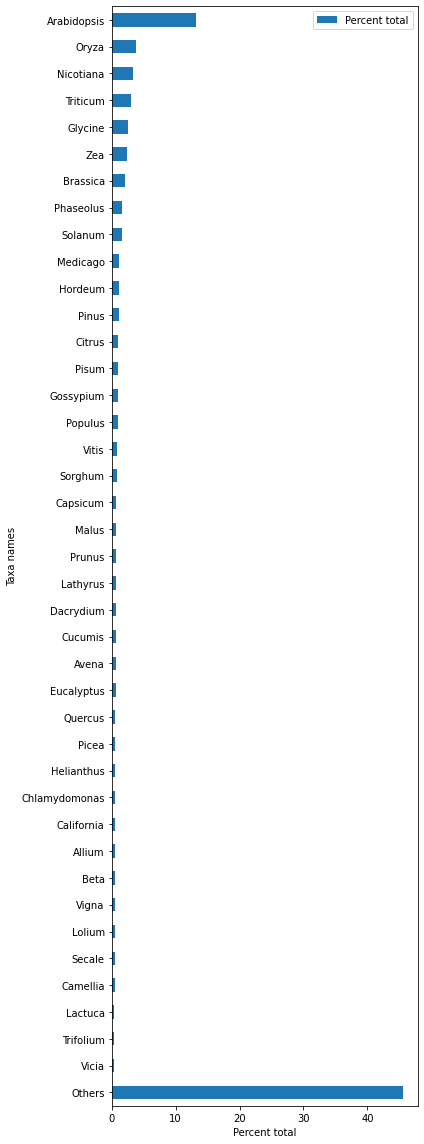

In [189]:
topX_barplot(40, genus_count_df, "genus", "viridiplantae")

### Top 100 genus, ordered with clustering

#### Get count dataframe, bounds, and xticklabels

In [96]:
topX = 100
level_offspr = "genus"
level_parent = "viridiplantae"
genus_ts100  = get_topX_ts_bin_counts(topX, match_csr, level_offspr, 
                             level_parent, genus_count_df, viridi_offspr_names)
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)
genus_ts100.shape, boundsX.shape, boundsY.shape, len(xticklabels)

#topX_idx: 100


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


((100, 50), (51,), (101,), 51)

#### Set yticklabels after building a prelim heatmap

(26, 84, 'Chenopodium', 'Arachis')

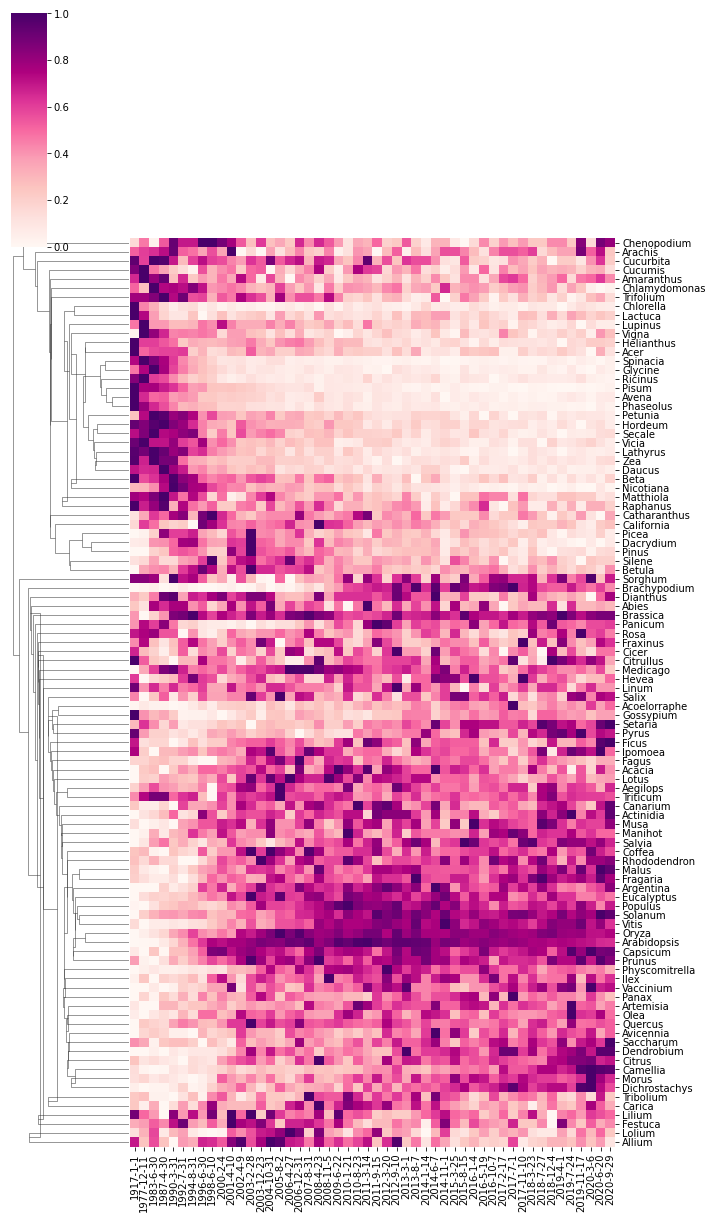

In [97]:
# Generate a preliminary heatmap, not scaled to get y-ordering
method = "centroid"

cgrid = sns.clustermap(genus_ts100, cmap="RdPu", 
                       row_cluster=True, col_cluster=False,
                       method=method,
                       xticklabels=xticklabels,
                       yticklabels=True)
# Set size  
plt.gcf().set_size_inches(10, 18)

# Save the heatmap
figure_file = f'fig5_1_{level_offspr}-of-{level_parent}_top{topX}'+ \
              f'_heatmap_{method}_prelim.pdf'
cgrid.savefig(work_dir / figure_file)

# Get the row order
order_idx = cgrid.dendrogram_row.reordered_ind
order_idx[0], order_idx[1], genus_ts.index[order_idx[0]], genus_ts.index[order_idx[1]]

In [98]:
# ytick labels
yticklabels = [genus_ts100.index[i] for i in order_idx]
genus_ts100_reordered = genus_ts100.reindex(yticklabels)
genus_ts100_reordered.head(3)

,2.507508e+08,4.258800e+08,5.468400e+08,6.389460e+08,7.126416e+08,7.783920e+08,8.361936e+08,8.975376e+08,9.497268e+08,9.869616e+08,...,1.521864e+09,1.532750e+09,1.543986e+09,1.554178e+09,1.564027e+09,1.574053e+09,1.583557e+09,1.592712e+09,1.601438e+09,1.609477e+09
Chenopodium,0.153846,0.461538,0.038462,0.538462,0.923077,0.692308,0.692308,1.00000,1.00000,0.884615,...,0.384615,0.230769,0.230769,0.423077,0.423077,0.230769,0.846154,0.153846,0.884615,0.807692
Arachis,0.520000,0.600000,0.640000,0.720000,0.920000,0.520000,0.480000,0.36000,0.56000,0.360000,...,0.520000,0.600000,0.160000,0.280000,0.360000,0.360000,0.880000,0.520000,0.720000,0.240000
Cucurbita,0.937500,0.593750,1.000000,0.968750,0.687500,0.281250,0.593750,0.71875,0.59375,0.562500,...,0.343750,0.218750,0.312500,0.000000,0.218750,0.218750,0.093750,0.406250,0.625000,0.218750


#### Plot scaled heatmap

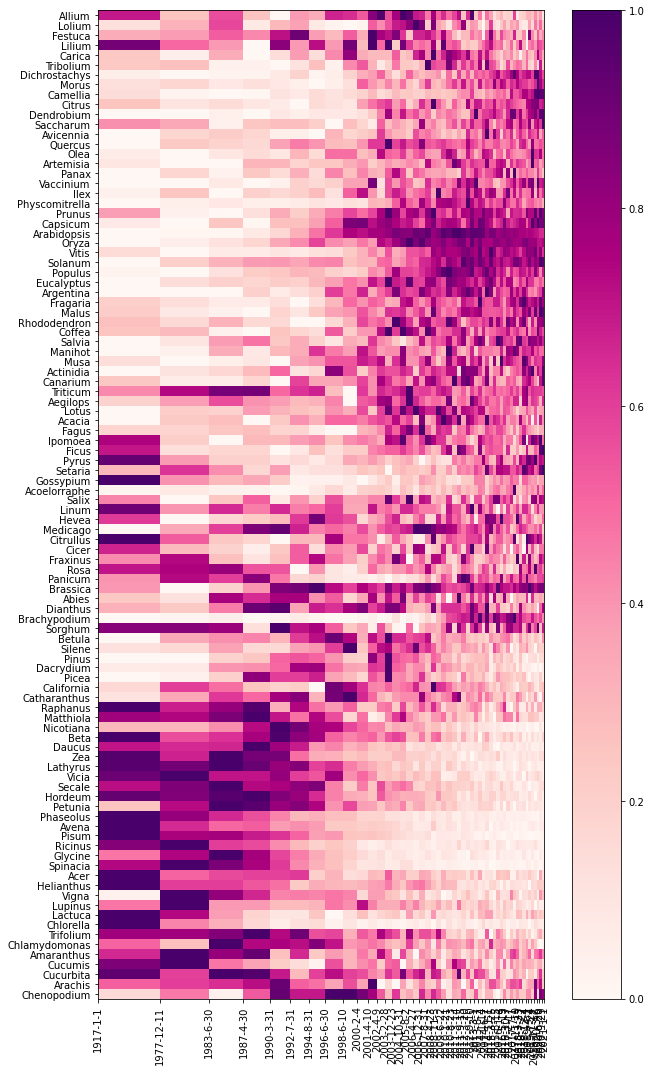

In [99]:
plot_scaled_heatmap(boundsX, boundsY, xticklabels, yticklabels, 
                genus_ts100_reordered, method, level_offspr, level_parent, topX)

### Alternative: order heatmap based on moving average

#### Define function to calculate moving average

In [93]:
def moving_avg_reorder_and_plot(values, step_size, level_offspr, level_parent, 
                                topX):
  dict_max_val_ts = {} # {1st_timestamp_in_window:{max_value:[taxa]}}

  #print("In moving_avg_reorder_and_plot:", values.shape)
  count = 0
  for taxa in values.index:
    # series for genus
    val_series = values.loc[taxa]
    val_max    = 0 # for setting value maximum
    val_max_ts = 0 # for setting last_timestamp_in_window for value maximum

    # Go through steps
    for idx in range(0, val_series.shape[0], step_size):
      vals     = val_series.iloc[idx:idx+step_size]
      val_mean = np.mean(vals)
      # new max found, set values
      if val_mean > val_max:
        val_max    = val_mean
        val_max_ts = vals.index[0]
      #print(val_max, val_max_ts)
    
    # set values in dict_max_val_ts
    if val_max_ts not in dict_max_val_ts:
      dict_max_val_ts[val_max_ts] = {val_max:[taxa]}
    elif val_max not in dict_max_val_ts[val_max_ts]:
      dict_max_val_ts[val_max_ts][val_max] = [taxa]
    # for topx=100, step_size=2, one val_max is the same
    else:
      print("Same val_max:", val_max_ts, val_max, taxa)
      dict_max_val_ts[val_max_ts][val_max].append(taxa)

  # Get the new yticklabels based on the ordered ts_max_val
  # was doing list(dict_max_val_ts.keys()), but this gives:
  #  TypeError: list indices must be integers or slices, not float
  max_val_ts   = [key for key in dict_max_val_ts.keys()]
  max_val_ts.sort()
  max_val_ts.reverse()
  new_yticks = []
  for ts in max_val_ts:
    #print(ts)
    val_maxs = [key for key in dict_max_val_ts[ts].keys()]
    val_maxs.sort()
    for val_max in val_maxs:
      #print("", val_max, len(dict_max_val_ts[ts][val_max]))
      #print(ts, val_max, dict_max_val_ts[ts][val_max])
      for taxa in dict_max_val_ts[ts][val_max]:
        new_yticks.append(taxa)
  #print(len(new_yticks))

  # Reorder dataframe
  values_reordered = values.reindex(new_yticks)
  #print("after reordering:", values_reordered.shape)

  # set bounts and xticks
  boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)

  plot_scaled_heatmap(boundsX, boundsY, xticklabels, new_yticks, 
    values_reordered, f"window{step_size}", level_offspr, level_parent, topX)

  return new_yticks, values_reordered


#### Top 100, step_size 3

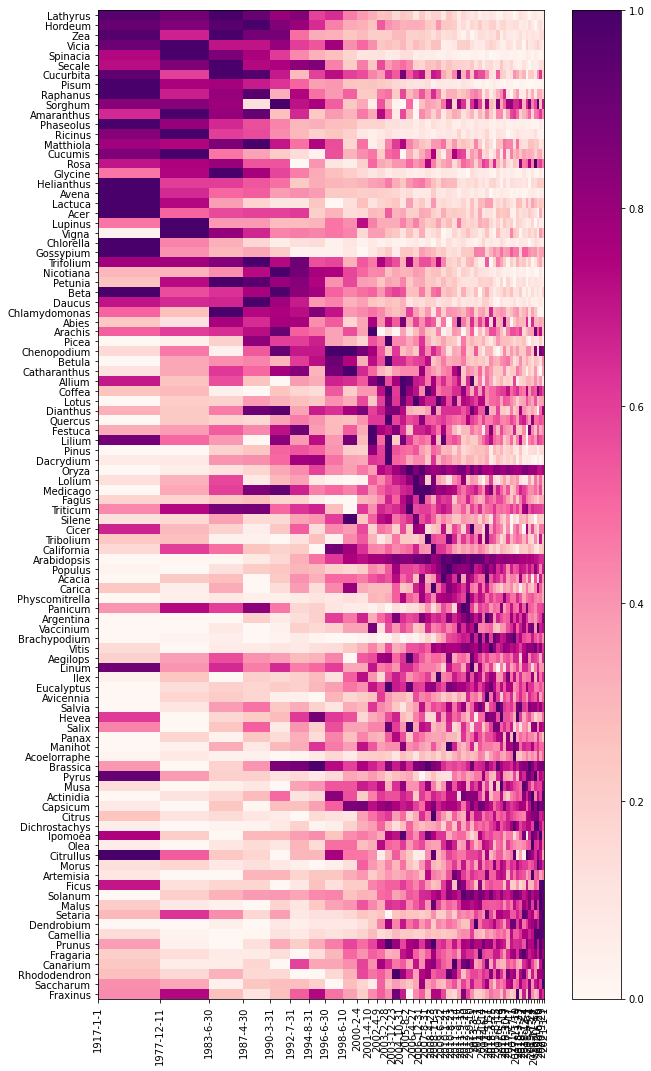

(100,
 ['Fraxinus', 'Saccharum', 'Rhododendron', 'Canarium', 'Fragaria'],
               250750799.0  425879999.0  546839999.0  638945999.0  712641599.0
 Fraxinus         0.421053     0.736842     0.263158     0.105263     0.263158
 Saccharum        0.413793     0.344828     0.034483     0.241379     0.275862
 Rhododendron     0.263158     0.157895     0.315789     0.157895     0.157895
 Canarium         0.235294     0.058824     0.058824     0.176471     0.000000
 Fragaria         0.204545     0.136364     0.068182     0.068182     0.136364)

In [100]:
topX      = 100
step_size = 3
new_yticks3, val_reordered3 = moving_avg_reorder_and_plot(
                      genus_ts100, step_size, level_offspr, level_parent, topX)
len(new_yticks3), new_yticks3[:5], val_reordered3.iloc[:5,:5]

#### Top 100, step size 2

Same val_max: 250750799.0 0.8688524590163935 Lactuca


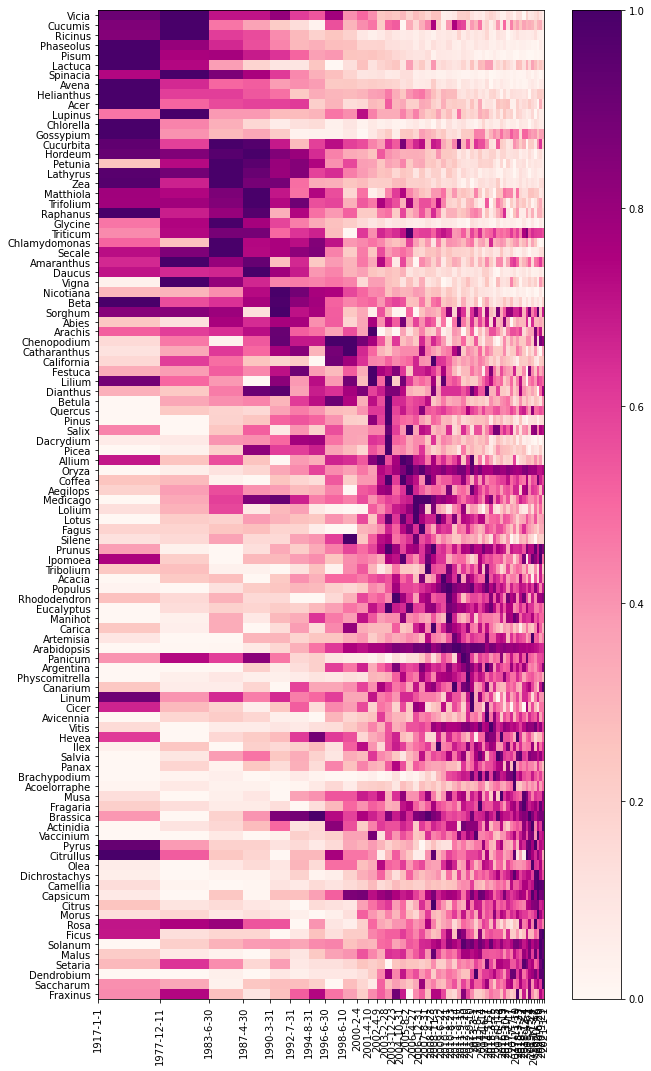

In [101]:
topX       = 100
step_size  = 2
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)
_, _       = moving_avg_reorder_and_plot(genus_ts100, step_size, level_offspr, 
                                         level_parent, topX)

#### Top 20, step size 3

#topX_idx: 20


100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


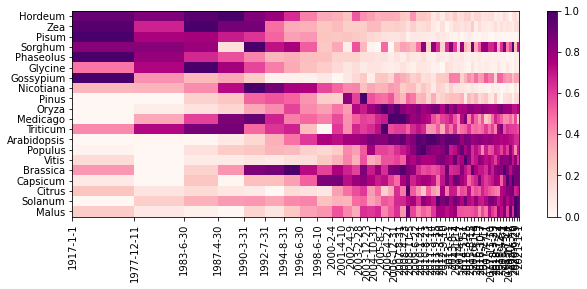

In [103]:
topX       = 20
step_size  = 3
genus_ts20 = get_topX_ts_bin_counts(topX, match_csr, level_offspr, level_parent, 
                                  genus_count_df, viridi_offspr_names)
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)
_, _       = moving_avg_reorder_and_plot(genus_ts20, step_size, level_offspr, 
                                         level_parent, topX)

#### Top 20, step size 2

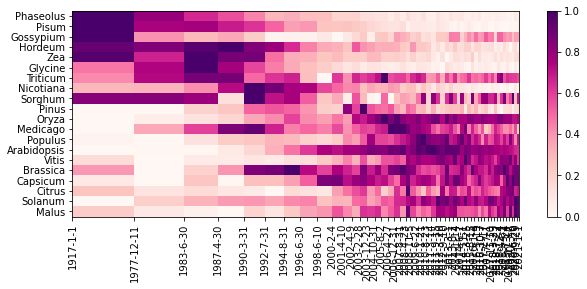

In [104]:
topX       = 20
step_size  = 2
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)
_, _       = moving_avg_reorder_and_plot(genus_ts20, step_size, level_offspr, 
                                         level_parent, topX)

#### Top 40, step size 2

#topX_idx: 40


100%|██████████| 40/40 [00:07<00:00,  5.43it/s]


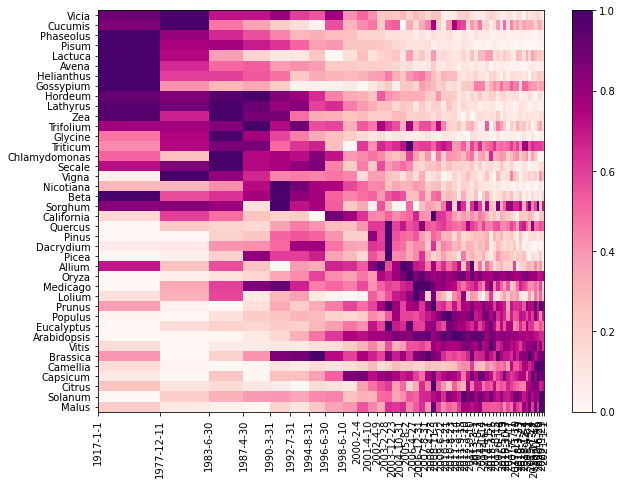

In [105]:
topX       = 40
step_size  = 2
genus_ts40 = get_topX_ts_bin_counts(topX, match_csr, level_offspr, level_parent, 
                                  genus_count_df, viridi_offspr_names)
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)
_, _       = moving_avg_reorder_and_plot(genus_ts40, step_size, level_offspr, 
                                         level_parent, topX)

## ___Family, order, special levels___

### Main function

#### Get tax ids and names for a taxonomic level

In [109]:
def get_level_names(level, offsprings):
  '''Get taxids and names for a particular taxonomic level, e.g., genus
  Args:
    level (str): taxonomic level specified in NCBI taxonomy to be counted
    offsprings (list): all taxon names that are offspring of a parent taxid, 
      this parent should be above the level specified. This is not checked. So
      need to make sure it is the case.
  Return:
    taxids_filter (list): tax ids that filtered against the offsprings list
    names_all (list): a list of taxon names corresponding to the tax ids
  '''
  
  # a list of all tax_ids
  taxids = rank_taxa[level]

  # filter taxids based on the list of viridiplantae ids
  taxids_filter = [tax_id for tax_id in taxids if tax_id in offsprings]

  names_dict, names_all = get_names(taxids_filter)
  print(f"level={level}, #taxids={len(taxids_filter)}, #names={len(names_all)}")

  return taxids_filter, names_all

In [107]:
def get_names(taxids):
  '''Get names based on a list of taxids'''
  taxids_names_dict = {viridi_names_dic[tax_id]['scientific name'][0]:1 
                       for tax_id in taxids}
  taxids_names  = list(taxids_names_dict.keys())

  return taxids_names_dict, taxids_names

#### Consolidate counts of the offsprings of each taxa

The idea behind this is that, if I want a count for a family F, then:
- Any mention of taxa that is offspring of F in an article will be counted as F.
- If multiple mention of taxa in F is mentioned in a single doc, then it is counted as 1.
- F should also be counted.

In [111]:
def get_consolidated_counts(taxids):
  '''Iterate through a list of taxids and consolidate the offspring counts of
     each taxid. E.g., the list can be for different families. Then each family
     is iterated to get the counts for the family and all its offsprings. The
     count is then summed for each family and set to 1 if the count is >0.
  Args:
    taxids (list): a list of taxids to iterate through
  Return:
    taxids_csr (csr): a matrix of consolidated counts, with column the same as
      the length of taxids.
    taxids_csr_csum (list): column sum of the above csr for debugging purpose 
  '''
  # Go through each taxa to get offsprings of that taxa
  taxids_sum = []

  for tax_id in tqdm(taxids):
    #print(tax_id, names_dic[tax_id]['scientific name'][0])
    # get offsprings of the taxa
    taxid_offspr          = get_offsprings(tax_id, parent_child, [])
    taxid_offspr_dict     = {name:1 for name in taxid_offspr}
    _, taxid_offspr_names = get_names(taxid_offspr)
    
    # Include the parent name so it can be counted
    parent = viridi_names_dic[tax_id]['scientific name'][0]
    parent_offspr_names = [parent] + taxid_offspr_names

    # Get the index of the parent and offsprings in the csr matrix
    csr_idx = [viridi_offspr_names.index(name) for name in parent_offspr_names
               if name in viridi_offspr_dict]
    sub_csr = match_csr[:, csr_idx]

    # Consolidate the columns
    sub_csr_sum = sub_csr.sum(axis=1)
    #print(sub_csr_sum.shape)

    # Add each sum array to a list
    taxids_sum.append(sub_csr_sum)

  # Convert the list to an array, then to csr
  #https://stackoverflow.com/questions/7200878/python-list-of-np-arrays-to-array
  taxids_array = np.hstack(taxids_sum)
  taxids_csr   = csr_matrix(taxids_array)
  #print("Col sum, before:", taxids_csr.sum(axis=0).ravel())

  # set any value >= 1 as 1
  taxids_csr[taxids_csr > 1] = 1
  taxids_csr_csum = np.squeeze(np.asarray(taxids_csr.sum(axis=0)))
  #print("Col sum, after :", taxids_csr_c_sum)

  return taxids_csr, taxids_csr_csum

### Family level

#### Set up

In [112]:
# tax_ids and names
fam_ids, fam_names    = get_level_names("family", viridi_offspr)
# count matrix, and column sum 
fam_csr, fam_csr_csum = get_consolidated_counts(fam_ids)
# family counts
fam_count_df = pd.DataFrame(list(zip(fam_names, fam_csr_csum)),
                        columns=("Taxa names", "Total"))
fam_count_df.head()

level=family, #taxids=912, #names=912


100%|██████████| 912/912 [00:21<00:00, 42.71it/s] 


,Taxa names,Total
0,Dunaliellaceae,220
1,Chlamydomonadaceae,2159
2,Spondylomoraceae,0
3,Volvocaceae,135
4,Oocystaceae,21


In [113]:
fam_count_file = work_dir / "Table_5_1_family_count.txt"
fam_count_df.to_csv(fam_count_file, sep='\t')

#### Top 100 fam

#topX_idx: 100


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


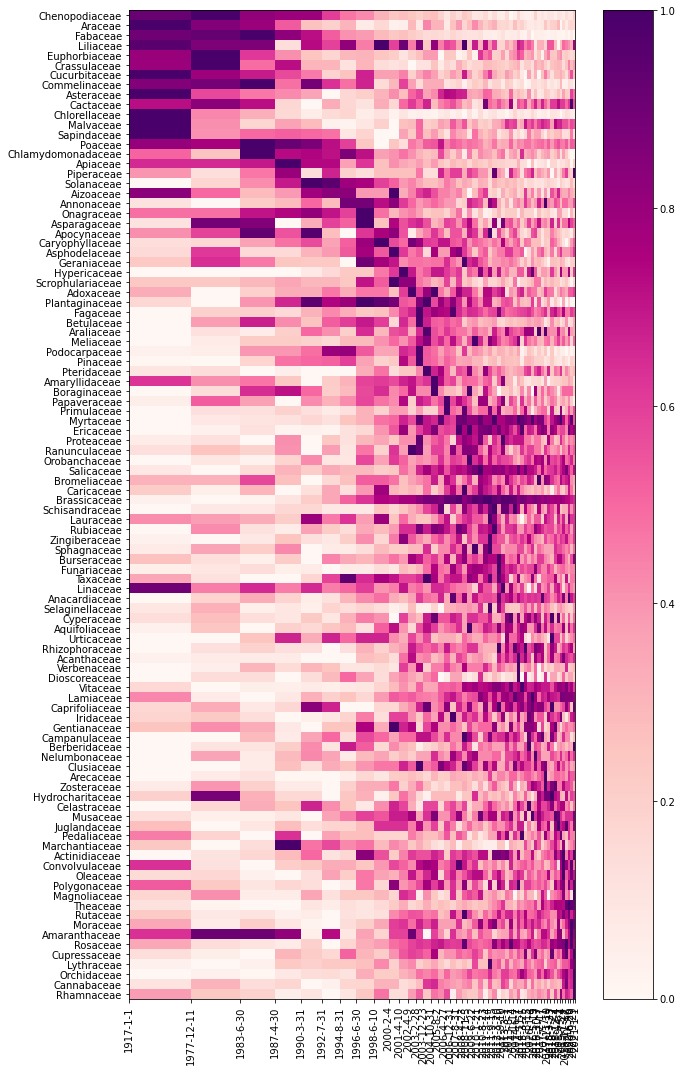

In [118]:
# Set topX and get counts in bins
topX = 100
level_offspr = "family"
level_parent = "viridiplantae"
fam_ts100 = get_topX_ts_bin_counts(topX, fam_csr, level_offspr, level_parent, 
                                  fam_count_df, fam_names)
# Set bounts and xticks
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)

# Set step size and plot
step_size = 2
_, _  = moving_avg_reorder_and_plot(fam_ts100, step_size, level_offspr, 
                                    level_parent, topX)

#### Top 40 fam

#topX_idx: 40


100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


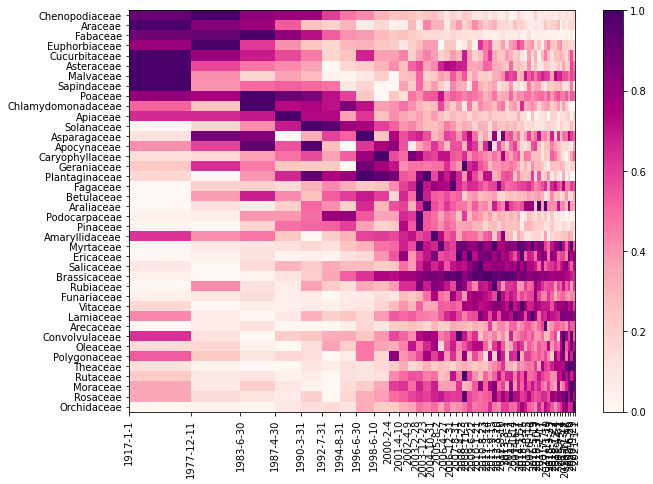

In [119]:
# Set topX and get counts in bins
topX = 40
level_offspr = "family"
level_parent = "viridiplantae"
fam_ts40 = get_topX_ts_bin_counts(topX, fam_csr, level_offspr, level_parent, 
                                  fam_count_df, fam_names)
# Set bounts and xticks
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)

# Set step size and plot
step_size = 2
_, _  = moving_avg_reorder_and_plot(fam_ts40, step_size, level_offspr, 
                                    level_parent, topX)

#### Top 20 fam

#topX_idx: 20


100%|██████████| 20/20 [00:03<00:00,  5.55it/s]


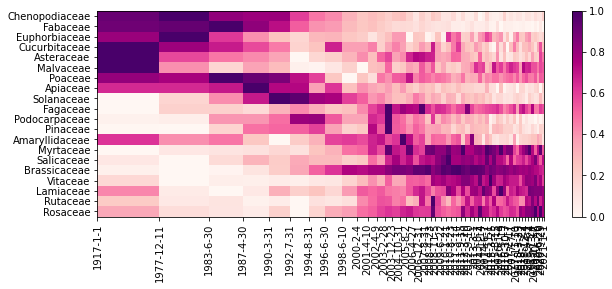

In [120]:
# Set topX and get counts in bins
topX = 20
level_offspr = "family"
level_parent = "viridiplantae"
fam_ts20 = get_topX_ts_bin_counts(topX, fam_csr, level_offspr, level_parent, 
                                  fam_count_df, fam_names)
# Set bounts and xticks
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)

# Set step size and plot
step_size = 2
_, _  = moving_avg_reorder_and_plot(fam_ts20, step_size, level_offspr, 
                                    level_parent, topX)

### Order level

level=order, #taxids=185, #names=185


100%|██████████| 185/185 [00:17<00:00, 10.65it/s]


#topX_idx: 20


100%|██████████| 20/20 [00:03<00:00,  5.58it/s]


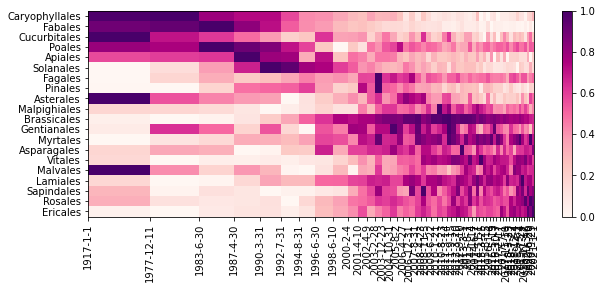

In [121]:
# tax_ids and names
order_ids, order_names    = get_level_names("order", viridi_offspr)
# count matrix, and column sum 
order_csr, order_csr_csum = get_consolidated_counts(order_ids)
# order counts
order_count_df = pd.DataFrame(list(zip(order_names, order_csr_csum)),
                        columns=("Taxa names", "Total"))

order_count_file = work_dir / "Table_5_1_order_count.txt"
order_count_df.to_csv(order_count_file, sep='\t')

# Set topX and get counts in bins
topX = 20
level_offspr = "order"
level_parent = "viridiplantae"
order_ts20 = get_topX_ts_bin_counts(topX, order_csr, level_offspr, level_parent, 
                                  order_count_df, order_names)
# Set bounts and xticks
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)

# Set step size and plot
step_size = 2
_, _  = moving_avg_reorder_and_plot(order_ts20, step_size, level_offspr, 
                                    level_parent, topX)

### Phyla/mix level

- Chlorophyta
- Charophyceae
- Zygnemophyceae 
- Anthocerotophyta (hornworts)
- Bryophyta (mosses)
- Marchantiophyta (liverworts)  
- Lycopodiopsida (clubmosses)
- Polypodiopsida (including horsetail)
- Acrogymnospermae 
- eudicotyledons
- Liliopsida (monocot)
- Magnoliopsida (flowering plants)

In [125]:
targets = ['Chlorophyta', 'Charophyceae', 'Zygnemophyceae', 'Anthocerotophyta',
           'Bryophyta', 'Marchantiophyta', 'Lycopodiopsida', 'Polypodiopsida',
           'Acrogymnospermae', 'eudicotyledons', 'Liliopsida', 'Magnoliopsida']

In [126]:
# get tax_id of targets
target_id_dict = {}
for tax_id in tqdm(viridi_names_dic):
  name = viridi_names_dic[tax_id]['scientific name'][0]
  if name in targets:
    target_id_dict[name] = tax_id

100%|██████████| 2444356/2444356 [00:01<00:00, 1352378.35it/s]


In [127]:
target_ids   = list(target_id_dict.values())
target_names = list(target_id_dict.keys())

target_csr, target_csr_csum = get_consolidated_counts(target_ids)
# family counts
target_count_df = pd.DataFrame(list(zip(target_names, target_csr_csum)),
                        columns=("Taxa names", "Total"))

target_count_file = work_dir / "Table_5_1_special_count.txt"
target_count_df.to_csv(target_count_file, sep='\t')
target_count_df

100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


,Taxa names,Total
0,Chlorophyta,4439
1,Marchantiophyta,848
2,Bryophyta,1925
3,Magnoliopsida,252010
4,Liliopsida,66476
5,Anthocerotophyta,180
6,eudicotyledons,197737
7,Zygnemophyceae,186
8,Polypodiopsida,1432
9,Charophyceae,297


#topX_idx: 12


100%|██████████| 12/12 [00:02<00:00,  5.53it/s]


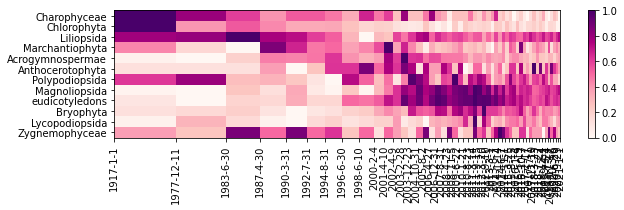

In [128]:
# Set topX and get counts in bins
topX = 12
level_offspr = "special"
level_parent = "viridiplantae"
target_ts = get_topX_ts_bin_counts(topX, target_csr, level_offspr, level_parent, 
                                   target_count_df, target_names)
# Set bounts and xticks
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)

# Set step size and plot
step_size = 2
_, _  = moving_avg_reorder_and_plot(target_ts, step_size, level_offspr, 
                                    level_parent, topX)

## ___Genus of a higher taxonomic level___

### Function

In [139]:
def count_genus_of_a_higher_level(level_parent, topX, step_size):
  '''Count and plot numbers of pubs for taxa that belong to a higher level taxon
  Args:
    level_parent (str): the higher level taxon
    topX (int): the topX genus to plot
    step_size (int): the sliding window step size for sorting genus
  '''
  
  # This could be set as a parameter so any level would work. But this require
  # additional thoughts about consolidating counts with a function I wrote
  # earlier. Got what I want any way and no time. So did not do it.
  level_offspr = "genus"

  # id of the higher leve
  tax_id, _    = get_name_dict(names_dmp_path, level_parent)
  # offsprings of the higher level taxa       l
  tax_offspr   = get_offsprings(tax_id, parent_child, [])
  # tax_ids and names of offsprings at the level_offspr
  tax_offspr_ids, tax_offspr_names = get_level_names(level_offspr, tax_offspr)

  # convert higher level taxon offspring names into a dict 
  tax_offspr_dict = {name:1 for name in tax_offspr_names}

  # Get indices of data for higher level taxon offspring names in the big csr
  # offspring_names is the list for all offspring of Viridiplantae, so will
  # will inclue offspring of any higher level taxon as long as it is below 
  # Viridiplantae
  tax_offspr_csr_idx  = [viridi_offspr_names.index(name) 
                        if name in viridi_offspr_dict else print("Not found:", name)
                        for name in tqdm(tax_offspr_names)] 

  # get count matrix, and column sum 
  tax_offspr_csr      = match_csr[:, tax_offspr_csr_idx]
  tax_offspr_csr_csum = np.squeeze(np.asarray(tax_offspr_csr.sum(axis=0)))

  # counts of offspring taxa for the higher level taxon
  tax_offspr_count_df = pd.DataFrame(
                          list(zip(tax_offspr_names, tax_offspr_csr_csum)),
                          columns=("Taxa names", "Total"))

  # Three taxa with names that can get confusing
  drop = ['Matthiola', 'California', 'Dichrostachys']
  tax_offspr_count_df = tax_offspr_count_df[
                                  ~tax_offspr_count_df['Taxa names'].isin(drop)]

  tax_offspr_count_file = f"Table_5_1_{level_parent}_{level_offspr}_count.txt"
  tax_offspr_count_df.to_csv(work_dir / tax_offspr_count_file, sep='\t')

  # get counts in bins of topX offspring taxa
  tax_offspr_ts = get_topX_ts_bin_counts(topX, tax_offspr_csr, level_offspr,
                            level_parent, tax_offspr_count_df, tax_offspr_names)

  # Set bounts and xticks
  boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)
  print(len(boundsY))
  # plot heatmap
  _, _  = moving_avg_reorder_and_plot(tax_offspr_ts, step_size, level_offspr, 
                                      level_parent, topX)

### TopX genus in Brassicaceae

Brassicaceae tax_id: 3700
level=genus, #taxids=401, #names=401


100%|██████████| 401/401 [00:00<00:00, 537.93it/s]


#topX_idx: 10


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


11


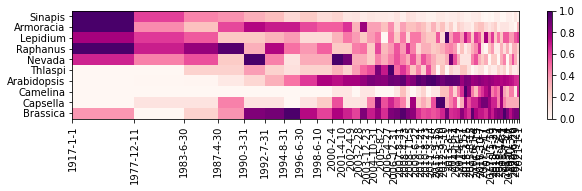

In [140]:
level_parent = "Brassicaceae" 
topX         = 10
step_size    = 2
count_genus_of_a_higher_level(level_parent, topX, step_size)

### TopX genus in Solanaceae

Solanaceae tax_id: 4070
level=genus, #taxids=106, #names=106


100%|██████████| 106/106 [00:00<00:00, 1240.14it/s]


#topX_idx: 10


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


11


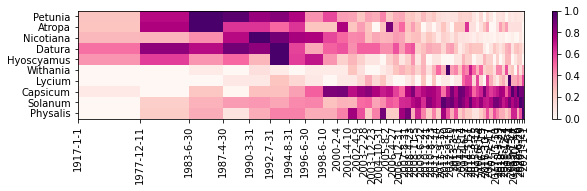

In [141]:
level_parent = "Solanaceae" 
topX         = 10
step_size    = 2
count_genus_of_a_higher_level(level_parent, topX, step_size)

### TopX genus in Fabaceae

Fabaceae tax_id: 3803
level=genus, #taxids=811, #names=811


100%|██████████| 811/811 [00:00<00:00, 876.75it/s]


#topX_idx: 20


100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


21


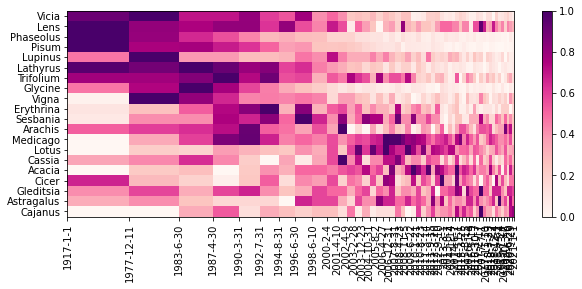

In [142]:
level_parent = "Fabaceae" 
topX         = 20
step_size    = 2
count_genus_of_a_higher_level(level_parent, topX, step_size)

### TopX genus in Poaceae

Poaceae tax_id: 4479
level=genus, #taxids=857, #names=857


100%|██████████| 857/857 [00:00<00:00, 10001.97it/s]


#topX_idx: 20


100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


21


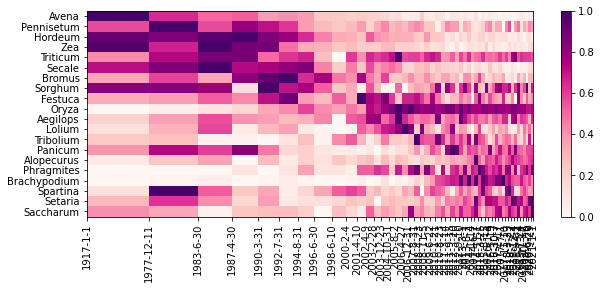

In [143]:

level_parent = "Poaceae" 
topX         = 20
step_size    = 2
count_genus_of_a_higher_level(level_parent, topX, step_size)

## ___Code testing___

### Testing parent-child parsing results

In [ ]:
'37868' in viridi_offspr

In [ ]:
'Achnatherum' in offspring_names

In [ ]:
rank_d

In [ ]:
# Spot check parent-child
len(parent_child['147383']), '37868' in parent_child['147383']

In [ ]:
children_147383 = '''
    Achnatherum   
    Aciachne   
    Amelichloa   
    Anatherostipa   
    Anemanthele   
    Austrostipa   
    Barkworthia   
    Celtica   
    Eriocoma   
    Hesperostipa   
    Jarava   
    Lorenzochloa   
    Macrochloa   
    Nassella   
    Neotrinia   
    Oloptum   
    Ortachne   
    Oryzopsis (ricegrass)   
    Pappostipa   
    Patis   
    Piptatheropsis   
    Piptatherum   
    Piptochaetium   
    Psammochloa   
    Pseudoeriocoma   
    Ptilagrostiella   
    Ptilagrostis   
    Stipa   
    Stipellula   
    Thorneochloa   
    Timouria   
    Trikeraia   
    x Eriosella'''

### Test string preprocessing

In [ ]:
doc = corpus['txt'][1]
doc = str(doc).strip()
doc = re.sub(r'[^\w\s]', '', doc)
doc

In [ ]:
children_147383_parsed = []
for child in children_147383.split("\n"):
  children_147383_parsed.append(child.strip())

In [ ]:
len(children_147383_parsed), len(parent_child['147383'])

In [ ]:
parent_child['147368']

In [ ]:
# Still missing 1, this is a synonym
for child in children_147383_parsed:
  if child not in debug_list:
    print(child)

In [ ]:
# Spot check child_parent
for child in parent_child[target_id]:
  print(child, taxa_rank[child], child_parent[child])

In [ ]:
# this was missing in the 2021 taxa dump file, now it is there
child_parent['2950019']

### Testing find names

#### Use list comprehension

In [ ]:
doc = corpus['txt_clean'][1]
results_ncbi = [name for name in viridi_offspr_names if(name in doc)]
print(results_ncbi)

In [ ]:
results_ncbi = [1 if(name in doc) else 0 for name in viridi_offspr_names]
print(sum(results_ncbi))

In [ ]:
# Note that here I add two spaces to pad the names, to prevent matching to
# substring.
results_usda = [name for name in common_names if(f" {name} " in doc)]
print(results_usda)

#results_usda = [1 if(f" {name} " in doc) else 0 for name in common_names ]
#print(sum(results_usda))

In [ ]:
## Get genus names for common matches and add the doc 
for cname in results_usda:
  genus = cnames[cname][0]
  doc += f" {genus}"
print(doc)


In [ ]:
# Do the count again
results_ncbi = [1 if(name in doc) else 0 for name in offspring_names]
print(sum(results_ncbi))

In [ ]:
# Get the non-zero indices
non0_idx = np.nonzero(results_ncbi)[0].tolist()
type(non0_idx), non0_idx

In [ ]:
test_col_idx = [1,2]
test_col_idx.extend(non0_idx)
test_col_idx

In [ ]:
[1]*3

#### Use ordered dict comprehension

In [ ]:
# test
test_names = ["eggplant", "corn", "spinach"]
[name if(f" {name} " in doc) else 0 for name in test_names ]

In [ ]:
OrderedDict((name, 1) if(f" {name} " in doc) else (name, 0) 
                                              for name in test_names)

In [ ]:
type(common_names), "eggplant" in common_names

In [ ]:
results_usda = OrderedDict(
  (name, 1) if(f" {name} " in doc) else (name, 0) for name in common_names)

In [ ]:
results_usda['eggplant'], results_usda['corn'], results_usda['spinach']

### Testing `get_match_csr`

In [ ]:
# testing
test_txt_clean = corpus['txt_clean'][:5]
test_match_csr = get_match_csr(test_txt_clean)

In [ ]:
# Expected 421628 x 26782
test_match_csr.shape

In [ ]:
col_sum = test_match_csr.sum(axis=0)
col_sum.shape

In [ ]:
non0_idx = col_sum.nonzero()[1]
non0_idx


In [ ]:
for idx in non0_idx:
  print(viridi_offspr_names[idx])

In [ ]:
# Spinach
test_txt_clean[0]

In [ ]:
# Solanum, Zea
test_txt_clean[1]

In [ ]:
# Arachis, Sesbania  
test_txt_clean[2]

In [ ]:
# barley  
test_txt_clean[3]

In [ ]:
# Soybean , Sesbania  
test_txt_clean[4]

### Testing `get_match_csr` to get run time estimate

https://stackoverflow.com/questions/28427236/set-row-of-csr-matrix

#### Create lists of values, row_idx, and col idx, then create csr

In [ ]:
def get_match_csr_v1(txt):
  row_idx   = []
  col_idx   = []
  csr_val   = []
  for row, doc in enumerate(tqdm(txt)):
    # Get the matching common names as a list
    results_usda = [name for name in common_names if(f" {name} " in doc)]

    # Add the results to doc
    for cname in results_usda:  # for each common name
      genus = cnames[cname][0]  # get the genus name
      doc += f" {genus}"        # add the genus name to doc
    
    # Match to NCBI names
    results_ncbi = [1 if(name in doc) else 0 for name in offspring_names]

    # Assign row_idx, col_idx, and values for non-zero results_ncbi
    non0_idx = np.nonzero(results_ncbi)[0].tolist()
    row_idx.extend([row]*len(non0_idx))
    col_idx.extend(non0_idx)
    csr_val.extend([1]*len(non0_idx))

  # create a sparse matrix with shape=(num_docs, num_names)
  match_csr = csr_matrix((csr_val, (row_idx, col_idx)),
                         shape=(corpus.shape[0], len(viridi_offspr_names)), 
                         dtype=np.int0)

  return match_csr


In [ ]:
test100 = corpus['txt_clean'][:100]
t = time()
test100_csr1 = get_match_csr_v1(test100)
print(time()-t)

#### Create empty match_csr first

In [ ]:
# Create empty match_csr, then create a tmp_csr with row_idx, col_idx, values,
# then add match_csr with the tmp_csr
def get_match_csr_v2(txt):

  # create an empty sparse matrix with shape=(num_docs, num_names)
  match_csr = csr_matrix((corpus.shape[0], len(viridi_offspr_names)), 
                         dtype=np.int0)

  for row, doc in enumerate(tqdm(txt)):
    # Get the matching common names as a list
    results_usda = [name for name in common_names if(f" {name} " in doc)]

    # Add the results to doc
    for cname in results_usda:  # for each common name
      genus = cnames[cname][0]  # get the genus name
      doc += f" {genus}"        # add the genus name to doc
    
    # Match to NCBI names
    results_ncbi = [1 if(name in doc) else 0 for name in viridi_offspr_names]

    # Assign row_idx, col_idx, and values for non-zero results_ncbi
    non0_idx = np.nonzero(results_ncbi)[0].tolist()
    row_idx  = [row]*len(non0_idx)
    col_idx  = non0_idx
    csr_val  = [1]*len(non0_idx)

    # Create a tmp csr to hold this row
    tmp_csr = csr_matrix((csr_val, (row_idx, col_idx)),
                         shape=(corpus.shape[0], len(offspring_names)), 
                         dtype=np.int0)

    # Update match_csr by adding tmp_csr to it
    match_csr = match_csr + tmp_csr

  return match_csr


In [ ]:
t = time()
test100_csr_v2 = get_match_csr_v2(test100)
print(time()-t)

#### Assign a list to a row in match_csr

In [ ]:
def get_match_csr_v3(txt):

  # create an empty sparse matrix with shape=(num_docs, num_names)
  match_csr = csr_matrix((corpus.shape[0], len(offspring_names)), 
                         dtype=np.int0)

  row_idx   = []
  col_idx   = []
  csr_val   = []
  for row, doc in enumerate(tqdm(txt)):
    # Get the matching common names as a list
    results_usda = [name for name in common_names if(f" {name} " in doc)]

    # Add the results to doc
    for cname in results_usda:  # for each common name
      genus = cnames[cname][0]  # get the genus name
      doc += f" {genus}"        # add the genus name to doc
    
    # Match to NCBI names
    results_ncbi = [1 if(name in doc) else 0 for name in viridi_offspr_names]

    # Assign row_idx, col_idx, and values for non-zero results_ncbi
    #non0_idx = np.nonzero(results_ncbi)[0].tolist()
    #row_idx.extend([row]*len(non0_idx))
    #col_idx.extend(non0_idx)
    #csr_val.extend([1]*len(non0_idx))

    # Assign new row values to match_csr
    match_csr[row, :] = results_ncbi

  return match_csr


In [ ]:
t = time()
test100_csr_v3 = get_match_csr_v3(test100)
print(time()-t)

#### Generate lil matrix instead

In [ ]:
# Similar to v3, but use lil matrix instead, tried coo also, but does not work
def get_match_lil_v4(txt):

  # create an empty sparse matrix with shape=(num_docs, num_names)
  # instead of csr, use lil
  match_lil = lil_matrix((corpus.shape[0], len(viridi_offspr_names)), 
                         dtype=np.int0)

  #row_idx   = []
  #col_idx   = []
  #csr_val   = []
  for row, doc in enumerate(tqdm(txt)):
    # Get the matching common names as a list
    results_usda = [name for name in common_names if(f" {name} " in doc)]

    # Add the results to doc
    for cname in results_usda:  # for each common name
      genus = cnames[cname][0]  # get the genus name
      doc += f" {genus}"        # add the genus name to doc
    
    # Match to NCBI names
    results_ncbi = [1 if(name in doc) else 0 for name in viridi_offspr_names]

    # Assign row_idx, col_idx, and values for non-zero results_ncbi
    #non0_idx = np.nonzero(results_ncbi)[0].tolist()
    #row_idx.extend([row]*len(non0_idx))
    #col_idx.extend(non0_idx)
    #csr_val.extend([1]*len(non0_idx))

    # Assign new row values to match_csr
    match_lil[row, :] = np.asarray(results_ncbi)

  return match_lil


In [ ]:
t = time()
test100_lil_v4 = get_match_lil_v4(test100)
print(time()-t)

#### Try dok_matrix

In [ ]:
def get_match_dok_v5(txt):

  # create an empty sparse matrix with shape=(num_docs, num_names)
  # instead of csr, use lil
  match_dok = dok_matrix((corpus.shape[0], len(offspring_names)), 
                         dtype=np.int0)

  row_idx   = []
  col_idx   = []
  csr_val   = []
  for row, doc in enumerate(tqdm(txt)):
    # Get the matching common names as a list
    results_usda = [name for name in common_names if(f" {name} " in doc)]

    # Add the results to doc
    for cname in results_usda:  # for each common name
      genus = cnames[cname][0]  # get the genus name
      doc += f" {genus}"        # add the genus name to doc
    
    # Match to NCBI names
    results_ncbi = [1 if(name in doc) else 0 for name in offspring_names]

    # Assign row_idx, col_idx, and values for non-zero results_ncbi
    #non0_idx = np.nonzero(results_ncbi)[0].tolist()
    #row_idx.extend([row]*len(non0_idx))
    #col_idx.extend(non0_idx)
    #csr_val.extend([1]*len(non0_idx))

    # Assign new row values to match_csr
    match_dok[row, :] = results_ncbi

  return match_dok


In [ ]:
t = time()
test100_dok_v5 = get_match_dok_v5(test100)
print(time()-t)

#### Use ordered dictionary comprehension

This is extremely slow...

In [ ]:
#https://www.pythonpool.com/python-ordereddict/
def get_match_csr_v6(txt):
  row_idx   = []
  col_idx   = []
  csr_val   = []
  for row, doc in enumerate(tqdm(txt)):
    # Get the matching common names as an ordered dict
    results_usda = OrderedDict((name, 1) if(f" {name} " in doc) else (name, 0) 
                               for name in common_names)

    # Add the results to doc
    for cname in results_usda:  # for each common name
      genus = cnames[cname][0]  # get the genus name
      doc += f" {genus}"        # add the genus name to doc
    
    # Match to NCBI names as an ordered dict
    results_ncbi = OrderedDict((name, 1) if(name in doc) else (name, 0) 
                               for name in offspring_names)

    # Assign row_idx, col_idx, and values for non-zero results_ncbi
    non0_idx = np.nonzero(results_ncbi.values())[0].tolist()
    row_idx.extend([row]*len(non0_idx))
    col_idx.extend(non0_idx)
    csr_val.extend([1]*len(non0_idx))

  # create a sparse matrix with shape=(num_docs, num_names)
  match_csr = csr_matrix((csr_val, (row_idx, col_idx)),
                         shape=(corpus.shape[0], len(offspring_names)), 
                         dtype=np.int0)

  return match_csr


In [ ]:
t = time()
test100_csr6 = get_match_csr_v6(test100)
print(time()-t)

#### Try multiprocessing

- https://superfastpython.com/multiprocessing-pool-for-loop/
- https://stackoverflow.com/questions/42749772/multiprocessing-how-to-use-pool-map-on-a-list-and-function-with-arguments
- https://python.omics.wiki/multiprocessing_map/multiprocessing_partial_function_multiple_arguments
- https://stackoverflow.com/questions/41920124/multiprocessing-use-tqdm-to-display-a-progress-bar

In [ ]:
data_pairs = [ [3,5], [4,3], [7,3], [1,6] ]

def myfunc(p):
  product_of_list = np.prod(p)
  return product_of_list


pool = multiprocessing.Pool(processes=4)
result_list = pool.map(myfunc, data_pairs)
print(result_list)

In [ ]:
for i in enumerate(test100):
  print(type(i))
  break

In [ ]:
def get_match_csr_v7(txt):

  with multiprocessing.Pool(processes=15) as pool:
    results_ncbi_list = list(tqdm(pool.imap(task, enumerate(txt)), 
                                  total=len(txt)))

  row_idx   = []
  col_idx   = []
  csr_val   = []
  for row, results_ncbi in enumerate(results_ncbi_list):
    non0_idx = np.nonzero(results_ncbi)[0].tolist()
    row_idx.extend([row]*len(non0_idx))
    col_idx.extend(non0_idx)
    csr_val.extend([1]*len(non0_idx))

  # create a sparse matrix with shape=(num_docs, num_names)
  match_csr = csr_matrix((csr_val, (row_idx, col_idx)),
                         shape=(txt.shape[0], len(offspring_names)), 
                         dtype=np.int0)

  return match_csr

def task(item):
  '''Task to parallelize
  Args:
    item (tuple): (row_number, doc)
  Return:
    results_ncbi (list): an offspring_name is present in the doc (1) or not(1)
  '''
  (row, doc) = item
  # Get the matching common names as a list
  results_usda = [name for name in common_names if(f" {name} " in doc)]

  # Add the results to doc
  for cname in results_usda:  # for each common name
    genus = cnames[cname][0]  # get the genus name
    doc += f" {genus}"        # add the genus name to doc
  
  # Match to NCBI names
  results_ncbi = [1 if(name in doc) else 0 for name in offspring_names]

  return results_ncbi

In [ ]:
t = time()
test100_csr7 = get_match_csr_v7(test100)
print(time()-t)

In [ ]:
test100_csr7.shape

In [ ]:
test100[1]

In [ ]:
offspring_names.index("Solanum"), offspring_names.index("Zea")

In [ ]:
# Expect to be 1, 1, 0
test100_csr7[1, 16432], test100_csr7[1, 4360], test100_csr7[1, 16431]

In [ ]:
test100[2]

In [ ]:
offspring_names.index("Arachis"), offspring_names.index("Sesbania")

In [ ]:
test100_csr7[2, 21986], test100_csr7[2, 21477]

### Testing getting counts for different timestamp bins

#### Construct topX dataframe

In [ ]:
# Read the top 100 genus names into a list
topX = 100

genus_count_df_topX = genus_count_df.nlargest(topX, 'Total')
top100_names        = genus_count_df_top100['Genus names'].tolist()

In [ ]:
# Get the csr indices for the top 100 names
top100_idx = [idx for idx, name in enumerate(viridi_genus_names)
              if name in top100_names]
              
# these are csr index, not for the top100_names list
len(top100_idx), top100_idx[:5]

In [ ]:
genus_csr[:,1].toarray().ravel().shape

In [ ]:
# Create a dict with {top_name:{timestamp:count}
top100_ts_count = {}
ts_all          = documents["Bins_left"] # the beginning ts of bins of all docs

# Go through each column. Only look at the top 100
for col_idx in tqdm(top100_idx):
  # Get column values
  col_val  = genus_csr[:,col_idx].toarray().ravel()
  top_name = viridi_genus_names[col_idx]
  top100_ts_count[top_name] = OrderedDict()
  for idx, ts in enumerate(ts_all):
    doc_val = col_val[idx]
    if ts not in top100_ts_count[top_name]:
      top100_ts_count[top_name][ts] = doc_val
    else:
      top100_ts_count[top_name][ts]+= doc_val

In [ ]:
len(top100_ts_count)

In [ ]:
ts_genus_count_df   = pd.DataFrame(top100_ts_count)
ts_genus_count_file = work_dir / "Table_5_1_genus_count_ts_bins.txt"
ts_genus_count_df.to_csv(ts_genus_count_file, sep='\t')

In [ ]:
ts_genus_count_df.sort_index(inplace=True)
ts_genus_count_df.head(10)

#### Get min-max scaled count dataframe

In [ ]:
# Do min-max scaling
#https://stackoverflow.com/questions/24645153/pandas-dataframe-columns-scaling-with-sklearn
ts_genus_count_minmax_df   = minmax_scaling(ts_genus_count_df,
                                            columns=ts_genus_count_df.columns)
ts_genus_count_minmax_file = work_dir / \
                                      "Table_5_1_genus_count_ts_bins_minmax.txt"
ts_genus_count_minmax_df.to_csv(ts_genus_count_minmax_file, sep='\t')
ts_genus_count_minmax_df.shape

In [ ]:
# Transpose  ts_genus_count_minmax_df so the genus are in rows, ts in columns.
genus_ts = ts_genus_count_minmax_df.transpose()
genus_ts.head(2)

### Testing sliding window

In [ ]:
sns.clustermap(test_df, cmap="RdPu", col_cluster=False)
plt.gcf().set_size_inches(10, 5)

In [ ]:
step_size = 3
new_yticks3, val_reordered3 = moving_avg_reorder(test_df, step_size)
len(new_yticks3), val_reordered3.shape

### Testing functions for counting other levels

In [ ]:
test_ids, test_names = get_level_names("family")
test_ids = test_ids[:10]
test_names = test_names[:10]

In [ ]:
test_taxids_csr, test_taxids_csr_c_sum = get_consolidated_counts(test_ids)

In [ ]:
test_count_df = pd.DataFrame(list(zip(test_names, test_taxids_csr_c_sum)),
                        columns=("Taxa names", "Total"))
test_count_df

In [ ]:
topX = 5
test_ts = get_topX_ts_bin_counts(topX, test_taxids_csr, "family", 
                                 test_count_df, test_names)
test_ts

In [ ]:
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)
test_ts.shape, boundsX.shape, boundsY.shape, len(xticklabels)

In [ ]:
step_size = 2
_, _  = moving_avg_reorder_and_plot(test_ts, step_size, topX)

### Testing: counts of taxa that belong to to a high level taxon

In [ ]:
# the higher level taxon
tax          = "Brassicaceae" 
# the lower offspring taxa level
level_offspr = "genus"        
# id of the higher leve
tax_id, _    = get_name_dict(names_dmp_path, tax)
# offsprings of the higher level taxa       l
tax_offspr   = get_offsprings(tax_id, parent_child, []) 
len(tax_offspr), check_duplicate(tax_offspr)

In [ ]:
# tax_ids and names of offsprings at the level_offspr
tax_offspr_ids, tax_offspr_names = get_level_names(level_offspr, tax_offspr)
print(tax_offspr_ids[:10], tax_offspr_names[:10])

In [ ]:
# convert higher level taxon offspring names into a dict 
tax_offspr_dict = {name:1 for name in tax_offspr_names}

# Get indices of data for higher level taxon offspring names in the big csr
# offspring_names is the list for all offspring of Viridiplantae, so will
# will inclue offspring of any higher level taxon as long as it is below Viridi.
tax_offspr_csr_idx  = [offspring_names.index(name) 
                       if name in viridi_offspr_dict else print("Not found:", name)
                       for name in tqdm(tax_offspr_names)]
len(tax_offspr_csr_idx)

In [ ]:
# count matrix, and column sum 
tax_offspr_csr = match_csr[:, tax_offspr_csr_idx]
tax_offspr_csr.shape

In [ ]:
tax_offspr_csr_csum = np.squeeze(np.asarray(tax_offspr_csr.sum(axis=0)))
tax_offspr_csr_csum

In [ ]:
# family counts
tax_offspr_count_df = pd.DataFrame(
                        list(zip(tax_offspr_names, tax_offspr_csr_csum)),
                        columns=("Taxa names", "Total"))
tax_offspr_count_file = work_dir / f"Table_5_1_{tax}_{level_offspr}_count.txt"
tax_offspr_count_df.to_csv(tax_offspr_count_file, sep='\t')

tax_offspr_count_df.head()

In [ ]:
# Set topX and get counts in bins
topX = 40
tax_offspr_ts = get_topX_ts_bin_counts(topX, tax_offspr_csr, "genus", 
                                       tax_offspr_count_df, tax_offspr_names)

In [ ]:
# Set bounts and xticks
boundsX, boundsY, xticklabels = set_bounds_and_xtick(topX)

# Set step size and plot
step_size = 2
_, _  = moving_avg_reorder_and_plot(tax_offspr_ts, step_size, topX)

### Test code for plot

#### barplot

In [ ]:
topX = 20
df   = genus_count_df

# Sort value in ascending order
df   = df.sort_values("Total")

# Get total counts and total for topX
total      = sum(df_sorted['Total'])
total_topX = 
df["Percent total"] = df_sorted['Total']/total*100



# Get the last topX rows from sorted dataframe
df_sorted.plot.barh(x='Taxa names', y='Percent total', rot=0)
plt.xlabel("Percent total")